In [1]:
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy import sparse

## Function Definitions

In [2]:
def call_option_price(t, S, r, sigma, K, T):
    ''' 
    Returns the true value of a European call option over the domain provided by t and S.
    
    t - ndarray of times
    S - ndarray of stock prices
    r - interest rate
    sigma - stock price standarard deviation
    K - strike price
    T - execution time
    '''
    
    # Set up mesh-grid
    x, y = numpy.meshgrid(t, S)
    
    d1 = (numpy.log(y / K) + (r + 0.5 * sigma**2) * (T - x)) / numpy.sqrt((T - t) * sigma**2)
    d2 = (numpy.log(y / K) + (r - 0.5 * sigma**2) * (T - x)) / numpy.sqrt((T - t) * sigma**2)
    
    term_1 = y * scipy.stats.norm.cdf(d1)
    term_2 = K * scipy.stats.norm.cdf(d2) * numpy.exp(-r * (T - x))
    
    w = term_1 - term_2
    
    return w

In [3]:
def put_option_price(t, S, r, sigma, K, T):
    ''' 
    Returns the true value of a European put option over the domain provided by t and S.
    
    t - ndarray of times
    S - ndarray of stock prices
    r - interest rate
    sigma - stock price standarard deviation
    K - strike price
    T - execution time
    '''
    
    x, y = numpy.meshgrid(t, S)
    d1 = (numpy.log(y / K) + (r + 0.5 * sigma**2) * (T - x)) / numpy.sqrt((T - t) * sigma**2)
    d2 = (numpy.log(y / K) + (r - 0.5 * sigma**2) * (T - x)) / numpy.sqrt((T - t) * sigma**2)
    
    term_1 = K * scipy.stats.norm.cdf(-d2) * numpy.exp(-r * (T - x))
    term_2 = y * scipy.stats.norm.cdf(-d1) 
    
    w = term_1 - term_2
    
    return w

In [4]:
def euler_method(l, m, r, sigma, K, t_0, T, S_Min, S_max, U_terminal, BC_S_Min, BC_S_Max):
    ''' 
    Returns the values (m + 2 by l grid) of a European put option estimated using the Forward euler method.
    
    l - number of gridpoints for time
    m - number of gridpoints for stock price
    r - interest rate
    sigma - stock price standarard deviation
    K - strike price
    t_0 - initial time
    T - execution time
    S_Min - lowest stock price
    S_max - highest stock price
    U_terminal - terminal condition
    BC_S_Min - boundary conditions at S_Min
    BC_S_Max - boundary conditions at S_Max
    '''
    # Construct grid
    S = numpy.linspace(S_Min, S_max, m + 2)
    delta_S = S[1] - S[0]
    t = numpy.linspace(t_0, T, l)
    delta_t = t[1] - t[0]
    
    # Construct diagonals
    main = delta_t * (sigma**2 * S[1:-1]**2 / delta_S**2 + r * numpy.ones(m))
    upper = 0.5 * delta_t * (sigma**2 * S[1:-1]**2 / delta_S**2 + r * S[1:-1] / delta_S)
    lower = 0.5 * delta_t * (sigma**2 * S[1:-1]**2 / delta_S**2 - r * S[1:-1] / delta_S)
    
    # Construct A
    A = scipy.sparse.spdiags([-lower, numpy.ones(m) + main, -upper], [-1, 0, 1], m, m).tocsr()

    # Set up the terminal and boundary conditions
    U = numpy.zeros((l, m + 2))
    U[-1] = U_terminal.copy()
    U[:, 0] = BC_S_Min
    U[:, -1] = BC_S_Max

    # Itiration to find the option value at each time
    for n, t_n in enumerate(t[:-1]):
        # Construct b
        b = U[- 1 - n, 1:-1].copy()
        b[0] += 0.5 * delta_t * (sigma**2 * S[1]**2 / delta_S**2 - r * S[1] / delta_S) * U[-1 - n, 0]
        b[-1] += 0.5 * delta_t * (sigma**2 * S[-2]**2 / delta_S**2 + r * S[-2] / delta_S) * U[- 1 - n, -1]
        
        # Solve the system
        U[- 2 - n, 1:-1] = scipy.sparse.linalg.spsolve(A, b)
    
    U = U.transpose()
    
    return U

In [5]:
def crank_nicholson(l, m, r, sigma, K, t_0, T, S_min, S_max, U_terminal, BC_S_Min, BC_S_Max):
    ''' 
    Returns the values (m + 2 by l grid) of a European put option estimated using the Crank-Nicholson method.
    
    l - number of gridpoints for time
    m - number of gridpoints for stock price
    r - interest rate
    sigma - stock price standarard deviation
    K - strike price
    t_0 - initial time
    T - execution time
    S_Min - lowest stock price
    S_max - highest stock price
    U_terminal - terminal condition
    BC_S_Min - boundary conditions at S_Min
    BC_S_Max - boundary conditions at S_Max
    '''
    # Construct grid
    S = numpy.linspace(S_Min, S_max, m + 2)
    delta_S = S[1] - S[0]
    t = numpy.linspace(t_0, T, l)
    delta_t = t[1] - t[0]
    
    # Construct diagonals
    main = delta_t * (sigma**2 * S[1:-1]**2 / delta_S**2 + r * numpy.ones(m))
    upper = 0.5 * delta_t * (sigma**2 * S[1:-1]**2 / delta_S**2 + r * S[1:-1] / delta_S)
    lower = 0.5 * delta_t * (sigma**2 * S[1:-1]**2 / delta_S**2 - r * S[1:-1] / delta_S)
    
    # Construct A and B, for A U^{n+1} = B U^{n}
    A = scipy.sparse.spdiags([0.5 * lower, numpy.ones(m) -0.5 *  main, 0.5 * upper], [-1, 0, 1], m, m).tocsr()
    B = scipy.sparse.spdiags([-0.5 * lower, numpy.ones(m) + 0.5 * main, -0.5 *upper], [-1, 0, 1], m, m).tocsr()
    
    # Set up the terminal and boundary conditions
    U = numpy.zeros((l, m + 2))
    U[-1] = U_terminal.copy()
    U[:, 0] = BC_S_Min
    U[:, -1] = BC_S_Max

    # Itiration to find the option value at each time
    for n, t_n in enumerate(t[:-1]):
        # Construct b
        b = A.dot(U[- 1 - n, 1:-1])
        b[0] += 0.25 * delta_t * (sigma**2 * S[1]**2 / delta_S**2 - r * S[1] / delta_S) * (U[-1 - n, 0] + U[-2 - n, 0])
        b[-1] += 0.25 * delta_t * (sigma**2 * S[-2]**2 / delta_S**2 + r * S[-2] / delta_S) * (U[- 1 - n, -1] + U[- 2 - n, -1])
        
        # Solve the system
        U[- 2 - n, 1:-1] = scipy.sparse.linalg.spsolve(B, b)
    
    U = U.transpose()
    
    return U

## Plots

### Colormap - Best Results

C:\Users\Edwin\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: divide by zero encountered in log
C:\Users\Edwin\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: divide by zero encountered in divide
C:\Users\Edwin\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: divide by zero encountered in log
C:\Users\Edwin\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: divide by zero encountered in divide


Errors:
Euler:  0.0124618079404
Crank-Nicholson 0.0124961882812


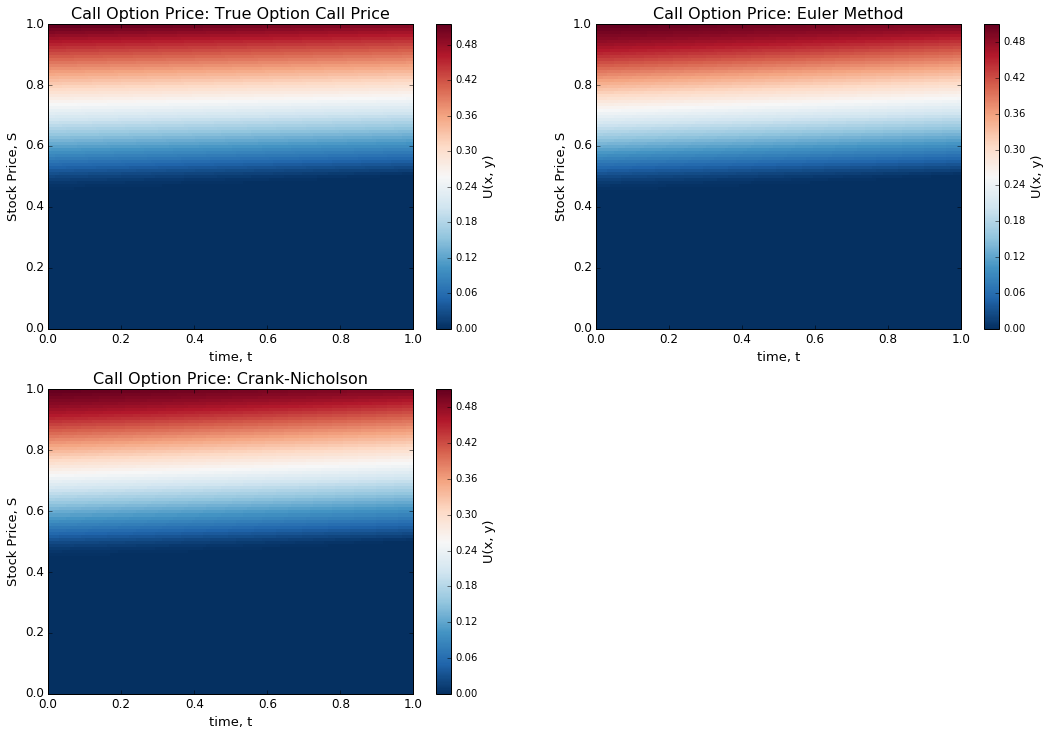

In [6]:
# Parameters
r = 0.05
S_Min = 0.0
S_Max = 1.0
sigma = 0.05 * S_Max
K = 0.5 * S_Max
t_0 = 0.0
T = 1.0

# Grid setup
l = 100
m = 100

t = numpy.linspace(t_0, T, l)
S = numpy.linspace(S_Min, S_Max, m + 2)
delta_S = S[1] - S[0]

# Find the call option values
U_true = call_option_price(numpy.linspace(t_0, T, l), numpy.linspace(S_Min, S_Max, m + 2), r, sigma, K, T)
U_EM = euler_method(l, m, r, sigma, K, t_0, T, S_Min, S_Max, U_true[:,-1], U_true[0], U_true[-1])
U_CN = crank_nicholson(l, m, r, sigma, K, t_0, T, S_Min, S_Max, U_true[:,-1], U_true[0], U_true[-1])

# Print the error
print 'Errors:'
print 'Euler: ', numpy.linalg.norm(delta_S * (U_true - U_EM), ord=numpy.infty)
print 'Crank-Nicholson', numpy.linalg.norm(delta_S * (U_true - U_CN), ord=numpy.infty)

x, y = numpy.meshgrid(t, S)

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 3)
fig.set_figheight(fig.get_figheight() * 3)

axes = fig.add_subplot(2, 2, 1)
sol_plot = axes.pcolor(x, y, U_true, cmap=plt.get_cmap('RdBu_r'))
axes.set_title("Call Option Price: True Option Call Price", fontsize=16)
axes.set_xlabel("time, t", fontsize=13)
axes.set_ylabel("Stock Price, S", fontsize=13)
axes.set_xlim((t_0, T))
axes.set_ylim((S_Min, S_Max))
axes.tick_params(labelsize=12)
cbar = fig.colorbar(sol_plot, ax=axes)
cbar.set_label("U(x, y)", fontsize=13)

axes = fig.add_subplot(2, 2, 2)
sol_plot = axes.pcolor(x, y, U_EM, cmap=plt.get_cmap('RdBu_r'))
axes.set_title("Call Option Price: Euler Method", fontsize=16)
axes.set_xlabel("time, t", fontsize=13)
axes.set_ylabel("Stock Price, S", fontsize=13)
axes.set_xlim((t_0, T))
axes.set_ylim((S_Min, S_Max))
axes.tick_params(labelsize=12)
cbar = fig.colorbar(sol_plot, ax=axes)
cbar.set_label("U(x, y)", fontsize=13)

axes = fig.add_subplot(2, 2, 3)
sol_plot = axes.pcolor(x, y, U_CN, cmap=plt.get_cmap('RdBu_r'))
axes.set_title("Call Option Price: Crank-Nicholson", fontsize=16)
axes.set_xlabel("time, t", fontsize=13)
axes.set_ylabel("Stock Price, S", fontsize=13)
axes.set_xlim((t_0, T))
axes.set_ylim((S_Min, S_Max))
axes.tick_params(labelsize=12)
cbar = fig.colorbar(sol_plot, ax=axes)
cbar.set_label("U(x, y)", fontsize=13)

plt.show()

### Convergence of $\Delta S$, Best Conditions

C:\Users\Edwin\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: divide by zero encountered in log
C:\Users\Edwin\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: divide by zero encountered in divide
C:\Users\Edwin\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: divide by zero encountered in log
C:\Users\Edwin\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: divide by zero encountered in divide


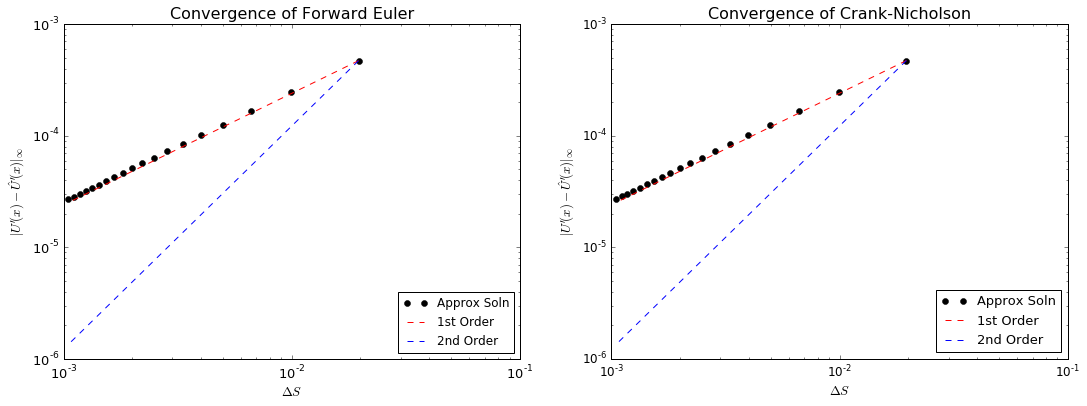

In [7]:
# Testing delta_S convergence
# Constant parameters
r = 0.05
S_min = 0.0
S_max = 1.0
sigma = 0.05 * S_max
K = 0.5 * S_max
t_0 = 0.0
T = 1.0

# Number of partitions for the time domain
l = 100
delta_t = (T - t_0) / l

S_partitions = range(50, 1000, 50)

delta_S = []
error_Euler = []
error_Crank = []

# Itirate through stock price partition number
for m in S_partitions:
    S = numpy.linspace(S_min, S_max, m + 2)
    delta_S.append(S[1] - S[0])
    
    # Find function values
    U_true = call_option_price(numpy.linspace(t_0, T, l), S, r, sigma, K, T)
    U_Euler = euler_method(l, m, r, sigma, K, t_0, T, S_min, S_max, U_true[:,-1], U_true[0], U_true[-1])
    U_Crank = crank_nicholson(l, m, r, sigma, K, t_0, T, S_min, S_max, U_true[:,-1], U_true[0], U_true[-1])
    
    # Find error by comparing the final values of the itiration, i.e. the initial U
    error_Euler.append(delta_S[-1] * numpy.linalg.norm(U_Euler[:, 0] - U_true[:, 0], ord=numpy.infty))
    error_Crank.append(delta_S[-1] * numpy.linalg.norm(U_Crank[:, 0] - U_true[:, 0], ord=numpy.infty))

# Error order function taken from class notes
order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
delta_S = numpy.array(delta_S)

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 3)
fig.set_figheight(fig.get_figheight() * 1.5)

# Forward Euler Convergence Plot
axes = fig.add_subplot(1, 2, 1)
axes.loglog(delta_S, error_Euler, 'ko', label='Approx Soln')
axes.loglog(delta_S, order_C(delta_S[0], error_Euler[0], 1.0) * delta_S**1.0, 'r--', label="1st Order")
axes.loglog(delta_S, order_C(delta_S[0], error_Euler[0], 2.0) * delta_S**2.0, 'b--', label="2nd Order")

axes.set_title("Convergence of Forward Euler", fontsize=16)
axes.set_xlabel("$\Delta S$", fontsize=13)
axes.set_ylabel("$|U'(x) - \hat{U}'(x)|_{\infty}$", fontsize=13)
axes.legend(loc=4)
axes.tick_params(labelsize=13)

# Crank-Nicholson Convergence Plot
axes = fig.add_subplot(1, 2, 2)
axes.loglog(delta_S, error_Crank, 'ko', label='Approx Soln')
axes.loglog(delta_S, order_C(delta_S[0], error_Crank[0], 1.0) * delta_S**1.0, 'r--', label="1st Order")
axes.loglog(delta_S, order_C(delta_S[0], error_Crank[0], 2.0) * delta_S**2.0, 'b--', label="2nd Order")

axes.set_title("Convergence of Crank-Nicholson", fontsize=16)
axes.set_xlabel("$\Delta S$", fontsize=13)
axes.set_ylabel("$|U'(x) - \hat{U}'(x)|_{\infty}$", fontsize=13)
axes.legend(loc=4, fontsize=13)
axes.tick_params(labelsize=12)

plt.show()

### Convergence of $\Delta S$ with $r = 0$ (Heat Equation)

C:\Users\Edwin\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: divide by zero encountered in log
C:\Users\Edwin\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: divide by zero encountered in divide
C:\Users\Edwin\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: divide by zero encountered in log
C:\Users\Edwin\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: divide by zero encountered in divide


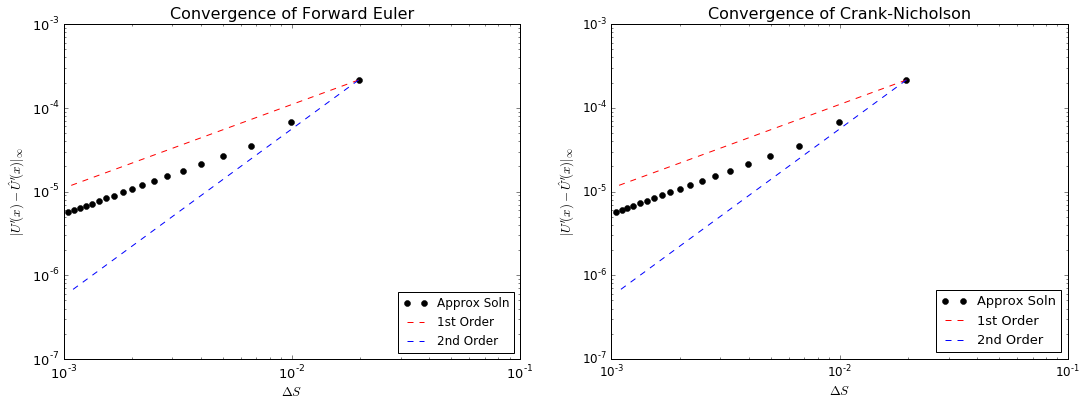

In [8]:
# Testing delta_S convergence
# Constant parameters
r = 0.00
S_min = 0.0
S_max = 1.0
sigma = 0.05 * S_max
K = 0.5 * S_max
t_0 = 0.0
T = 1.0

# Number of partitions for the time domain
l = 100
delta_t = (T - t_0) / l

S_partitions = range(50, 1000, 50)

delta_S = []
error_Euler = []
error_Crank = []

# Itirate through stock price partition number
for m in S_partitions:
    S = numpy.linspace(S_min, S_max, m + 2)
    delta_S.append(S[1] - S[0])
    
    # Find function values
    U_true = call_option_price(numpy.linspace(t_0, T, l), S, r, sigma, K, T)
    U_Euler = euler_method(l, m, r, sigma, K, t_0, T, S_min, S_max, U_true[:,-1], U_true[0], U_true[-1])
    U_Crank = crank_nicholson(l, m, r, sigma, K, t_0, T, S_min, S_max, U_true[:,-1], U_true[0], U_true[-1])
    
    # Find error by comparing the final values of the itiration, i.e. the initial U
    error_Euler.append(delta_S[-1] * numpy.linalg.norm(U_Euler[:, 0] - U_true[:, 0], ord=numpy.infty))
    error_Crank.append(delta_S[-1] * numpy.linalg.norm(U_Crank[:, 0] - U_true[:, 0], ord=numpy.infty))

# Error order function taken from class notes
order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
delta_S = numpy.array(delta_S)

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 3)
fig.set_figheight(fig.get_figheight() * 1.5)

# Forward Euler Convergence Plot
axes = fig.add_subplot(1, 2, 1)
axes.loglog(delta_S, error_Euler, 'ko', label='Approx Soln')
axes.loglog(delta_S, order_C(delta_S[0], error_Euler[0], 1.0) * delta_S**1.0, 'r--', label="1st Order")
axes.loglog(delta_S, order_C(delta_S[0], error_Euler[0], 2.0) * delta_S**2.0, 'b--', label="2nd Order")

axes.set_title("Convergence of Forward Euler", fontsize=16)
axes.set_xlabel("$\Delta S$", fontsize=13)
axes.set_ylabel("$|U'(x) - \hat{U}'(x)|_{\infty}$", fontsize=13)
axes.legend(loc=4)
axes.tick_params(labelsize=13)

# Crank-Nicholson Convergence Plot
axes = fig.add_subplot(1, 2, 2)
axes.loglog(delta_S, error_Crank, 'ko', label='Approx Soln')
axes.loglog(delta_S, order_C(delta_S[0], error_Crank[0], 1.0) * delta_S**1.0, 'r--', label="1st Order")
axes.loglog(delta_S, order_C(delta_S[0], error_Crank[0], 2.0) * delta_S**2.0, 'b--', label="2nd Order")

axes.set_title("Convergence of Crank-Nicholson", fontsize=16)
axes.set_xlabel("$\Delta S$", fontsize=13)
axes.set_ylabel("$|U'(x) - \hat{U}'(x)|_{\infty}$", fontsize=13)
axes.legend(loc=4, fontsize=13)
axes.tick_params(labelsize=12)

plt.show()